# Курсовая работа 
## "Машинное обучение в задачах распознавания голоса"



### Цель: 
### Определить пол человека на основе характеристик его голоса при помощи моделей машинного обучения

### План:  
1. **Подбор данных**:   
Изучение и выбор подходящего набора данных для задачи распознавания голоса.

2. **Описание данных**:   
Детальное описание выбранных данных, включая их структуру, количество записей, признаки и целевую переменную. Это включает в себя первичный анализ данных.

3. **Исследовательский анализ данных**:   
Проведение исследовательского анализа данных, включая статистический анализ, анализ пропущенных значений, анализ выбросов и корреляционный анализ.

4. **Визуализация данных**:   
Создание графиков и диаграмм для визуального представления данных и выявления важных взаимосвязей и паттернов.

5. **Предобработка данных**:  
Подготовка данных для моделирования, включая очистку данных, масштабирование признаков и разделение данных на обучающую и тестовую выборки.

6. **Обучение классических моделей классификации**:   
Обучение различных моделей классификации, таких как логистическая регрессия, деревья решений, случайный лес, SVM. Это также может включать в себя настройку гиперпараметров моделей.

7. **Получение метрик моделей**:   
Вычисление и анализ ключевых метрик моделей, таких как точность, полнота, F1-оценка и ROC-AUC, для оценки и сравнения производительности моделей.

8. **Обучение Keras модели**:  
Построение и обучение нейронной сети с использованием Keras для сравнения с классическими моделями классификации.

9. **Сравнение метрик всех моделей**:  
Сравнение производительности всех обученных моделей на основе вычисленных метрик, включая визуализацию результатов для лучшего понимания.

10. **Выводы**:   
Формулирование окончательных выводов о производительности моделей, включая их сильные и слабые стороны.

Определение пола человека (мужского или женского) на основе образца его голоса поначалу кажется простой задачей. Зачастую человеческое ухо легко уловит разницу между мужским и женским голосом уже с первых нескольких произнесенных слов.   
Модель построена с использованием 3168 записанных образцов мужских и женских голосов, речи и высказываний. Образцы обрабатываются с помощью акустического анализа, а затем применяются к алгоритму искусственного интеллекта/машинного обучения для изучения гендерных особенностей.

Для этой цели мы собираемся использовать разные модели классификации: От классических моделей до Keras - линейнего стека слоев нейронной сети.

In [51]:
import numpy as np
import pandas as pd
from io import StringIO

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, plot_confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, cross_val_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.interpolate import UnivariateSpline

import warnings
warnings.filterwarnings('ignore')

kfold = KFold(n_splits=5)

In [3]:
# Random Forest feature importance Function
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'Importance':m.feature_importances_}
                       ).sort_values('Importance', ascending=False)

In [4]:
# Random Forest feature importance 
def plot_fi(fi):
    return fi.plot('cols', 'Importance', 'barh', figsize=(12,8), legend=False)

## Подбор датасета 

В открытых источниках был найден набор данных `voice.csv` со сбалансированным набором записей об акустических параметрах голосов людей с указанием их пола (male и female). Он содержит достаточно данных для качественного обучения моделей машинного обучения.


## Исследовательский анализ данных

In [5]:
path = "voice.csv"
voiceDf = pd.read_csv(path)

voiceDf.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [6]:
voiceDf.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


In [7]:
voiceDf.shape

(3168, 21)

## Описание набора данных
- Набор данных содержит 21 столбец (20 атрибутов и 1 целевой признак - пол)
- Размеры набора данных: 3168 x 21

- __Цель: Классифицировать пол на основе особенностей голоса.__  

### Признаки и таргет набора данных:
- **meanfreq**: средняя частота (в кГц)
- **sd**: стандартное отклонение частоты
- **median**: медианная частота (в кГц)
- **Q25**: первый квантиль (в кГц)
- **Q75**: третий квантиль (в кГц)
- **IQR**: интерквартильный размах (в кГц)
- **skew**: асимметрия
- **kurt**: эксцесс
- **sp.ent**: спектральная энтропия
- **sfm**: спектральная плоскость
- **centroid**: частотный центроид (см. specprop)
- **peakf**: пиковая частота (частота с наибольшей энергией)
- **meanfun**: среднее значение основной частоты, измеренной в акустическом сигнале
- **minfun**: минимальная основная частота, измеренная в акустическом сигнале
- **maxfun**: максимальная основная частота, измеренная в акустическом сигнале
- **meandom**: среднее значение доминирующей частоты, измеренной в акустическом сигнале
- **mindom**: минимальная доминирующая частота, измеренная в акустическом сигнале
- **maxdom**: максимальная доминирующая частота, измеренная в акустическом сигнале
- **dfrange**: диапазон доминирующей частоты, измеренной в акустическом сигнале
- **modindx**: индекс модуляции. Накопленная абсолютная разница между соседними измерениями основных частот, деленная на диапазон частот
- **label**: пол (мужчина или женщина)


### Подготовка данных

In [8]:
voiceDf.dtypes.unique()

array([dtype('float64'), dtype('O')], dtype=object)

**Все признаки - численные, таргет - object.**

In [9]:
voiceDf.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

**Во всех признаках отсутствуют пропуски.**

Далее преобразуем целевую переменную в численный тип.  
Воспользуемся label_encoder, ведь у нас только 2 пола:

In [10]:
voiceDf["label"] = LabelEncoder().fit_transform(voiceDf["label"]) # 1 - male , 0 - female

### Визуализация данных

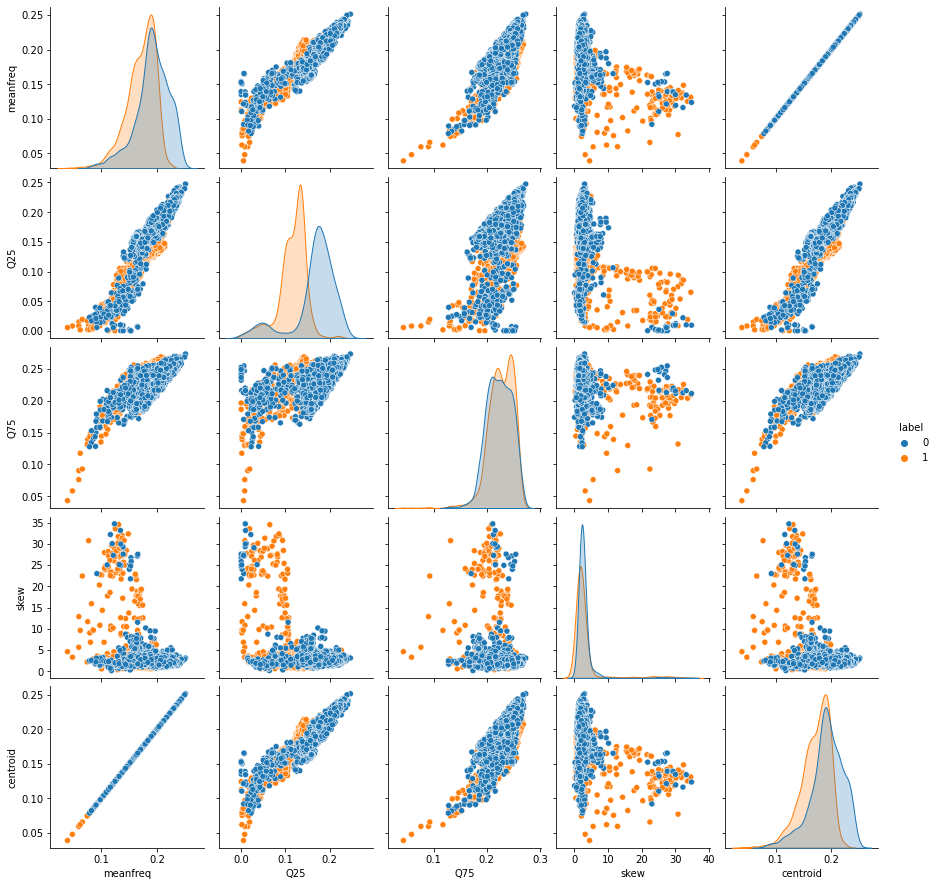

In [11]:
sns.pairplot(voiceDf[['meanfreq', 'Q25', 'Q75', 'skew', 'centroid', 'label']], hue='label');

**Pairplot построен для демонстрации взаимосвязей между признаками в наборе данных. Мы видим, что асимметрия и квартили имеют слабую связь, в отличие от "meanfreq" и "центроида", между которыми наблюдается сильная связь.**

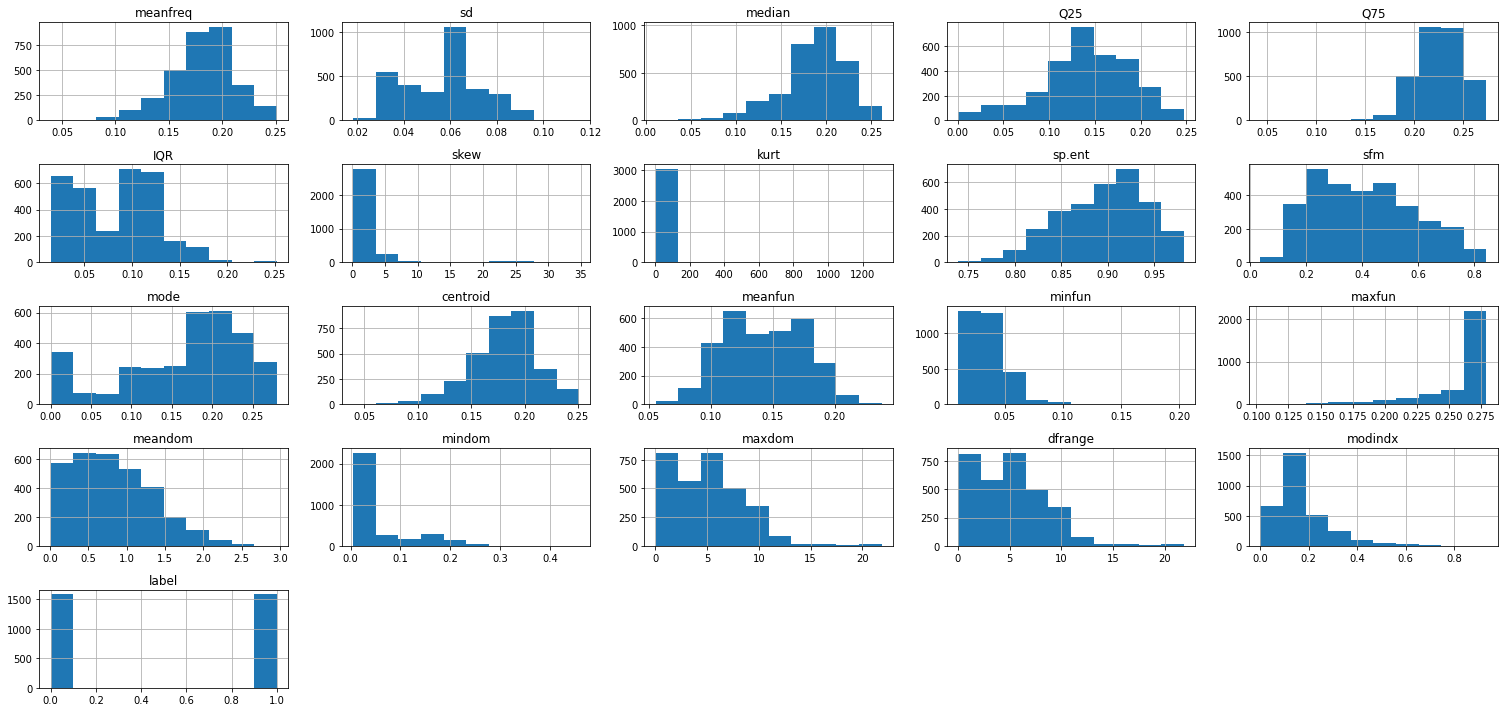

In [12]:
voiceDf.hist(figsize=(21, 10))

plt.tight_layout()
plt.show()

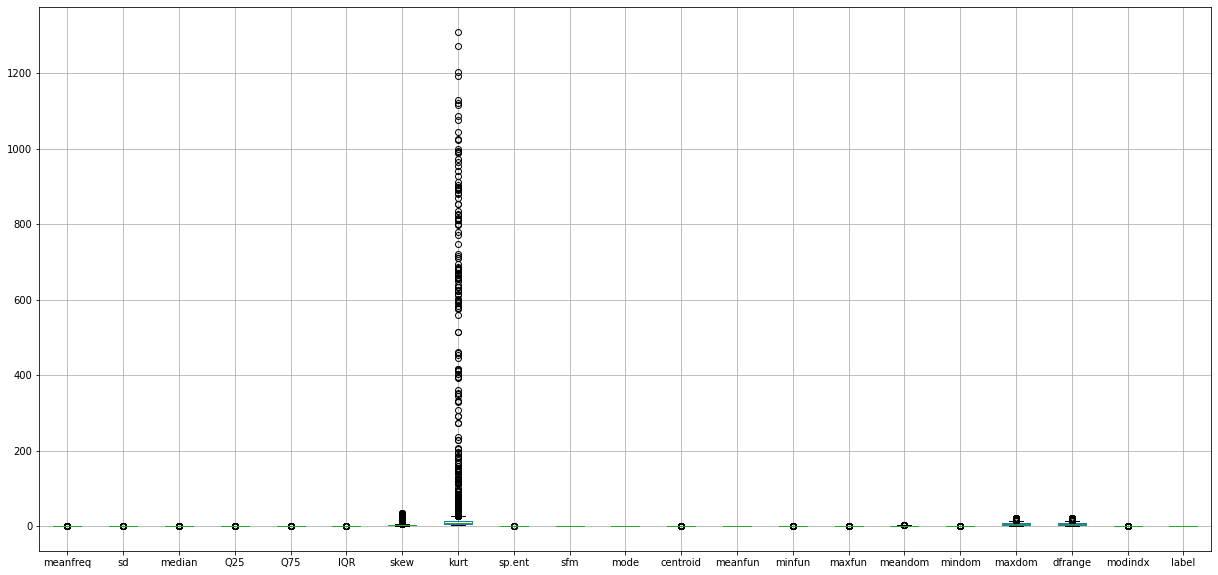

In [13]:
voiceDf.boxplot(figsize=(21, 10))

plt.show()

Выше представлены столбчатые диаграммы и boxplot каждого атрибута, которые позволяют увидеть наличие выбросов в данных. Изучив их, мы можем заметить, что __данные содержат не много выбросов__. Наибольшее количество выбросов наблюдается в признаках `skew` (асимметрия) и `kurt` (эксцесс).   
Мы видим, что __данные не смещены__, так как они __равномерно распределены между классами__ (50% мужчин, 50% женщин) - __дисбаланс классов отсутствует__.

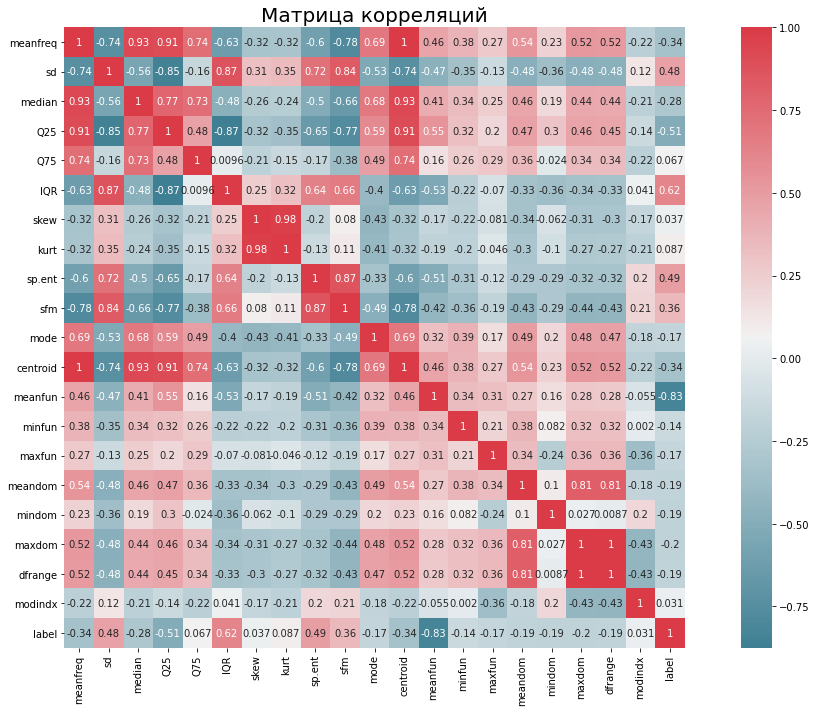

In [14]:
f, ax = plt.subplots(figsize=(16, 10))
corr = voiceDf.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

plt.title('Матрица корреляций', fontsize=20)
plt.tight_layout()
plt.show()

**Эта тепловая карта показывает корреляции между признаками.   
Заметим положительную корреляцию между label и IQR, label и sp.ent, а также сильную отрицательную корреляцию между label и meanfun.**

## Предобработка данных

**Сначала мы разделяем набор данных на признаки и таргет**

In [15]:
gender_label = voiceDf.iloc[:, -1].to_numpy()
voiceDf1 = voiceDf.iloc[:, :-1]

**Затем делим на тренировочную и тестовые выборки**

In [16]:
voiceX_train, voiceX_test, voiceY_train, voiceY_test = train_test_split(voiceDf1, gender_label, test_size=0.3, random_state=42)

**Стандартизация признаков**
- Обучаем scaler на тренировочных признаках
- Трансформируем тестовые. 


In [17]:
scaler = StandardScaler()
voiceX_train = scaler.fit_transform(voiceX_train)
voiceX_test = scaler.transform(voiceX_test)

## Модели машинного обучения

В этом разделе мы обучим несколько моделей классификации, оценим их, составим итоговую таблицу метрик для общих выводов.

### Логистическая регрессия 

Применим для нахождения лучших параметров **поиск по сетке**

In [18]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'max_iter': list(range(100, 800, 100)),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
%time grid_search.fit(voiceX_train, voiceY_train)

print("Лучшие параметры: ", grid_search.best_params_)
print("Лучший Score: ", grid_search.best_score_)

CPU times: user 2min 38s, sys: 51.7 s, total: 3min 30s
Wall time: 2min 2s
Лучшие параметры:  {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best Score:  0.9733847843328656


Поиск по сетке показал, что в целом значения по умолчанию в LogisticRegression подходят для лучшего результата, изменив только гиперпараметр ```solver``` на 'saga', что объясняется размерностью датасета.

##### Обучение и предсказание с использованием лучшей модели логистической регрессии.

In [19]:
best_logreg = grid_search.best_estimator_
voice_pred_best = best_logreg.predict(voiceX_test)

# Оценка метрик для найденной модели
voice_score_logreg = accuracy_score(voice_pred_best, voiceY_test)
accuracy_results_logreg = cross_val_score(best_logreg, voiceX_train, voiceY_train, cv=kfold).mean()
prf_logreg = precision_recall_fscore_support(voiceY_test, voice_pred_best, average='macro')
Precision_logreg = prf_logreg[0]
Recall_logreg = prf_logreg[1]
f1_logreg = prf_logreg[2]

##### Визуализация матрицы ошибок для лучшей модели логистической регрессии

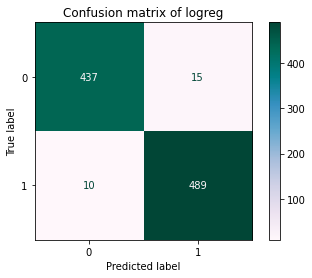

In [20]:
plot_confusion_matrix(best_logreg, voiceX_test, voiceY_test, cmap='PuBuGn')
plt.title('Confusion matrix of logreg')
plt.show()

### К-Ближайших соседей (KNN)

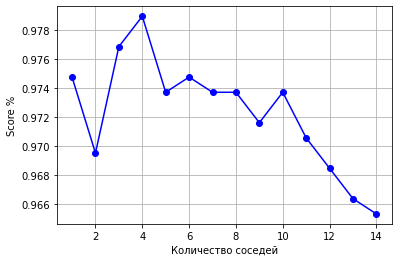

In [21]:
# сначала найдем оптимальное n_neighbors
knn_valid_score_list = []
n_neighbors_num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

for i in range(1,15):
    test_knn = KNeighborsClassifier(n_neighbors=i)
    test_knn.fit(voiceX_train, voiceY_train)
    knn_valid_score_list.append(test_knn.score(voiceX_test, voiceY_test))
    
plt.plot(n_neighbors_num,  knn_valid_score_list, "b")
plt.plot(n_neighbors_num,  knn_valid_score_list, "bo")
plt.xlabel("Количество соседей")
plt.ylabel("Score %")
plt.grid(True)
plt.show()

**Лучший результат при n_neighbors = 4, используем такое значение параметра.** 

In [22]:
# Учим лучшую модель KNN
%time knn = KNeighborsClassifier(n_neighbors=4).fit(voiceX_train, voiceY_train)

voice_pred_knn=knn.predict(voiceX_test)
prf_knn=precision_recall_fscore_support(voiceY_test, voice_pred_knn, average='macro')

# Смотрим метрики 
voice_score_knn = accuracy_score(voice_pred_knn, voiceY_test)
accuracy_results_knn = cross_val_score(knn, voiceX_train, voiceY_train, cv=kfold).mean()
Precision_knn = prf_knn[0]
Recall_knn = prf_knn[1]
f1_knn = prf_knn[2]

CPU times: user 6.18 ms, sys: 51 µs, total: 6.23 ms
Wall time: 6.1 ms


После вычисления метрик строим confusion_matrix

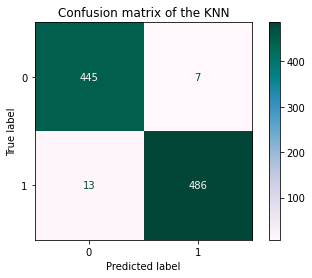

In [23]:
plot_confusion_matrix(knn, voiceX_test, voiceY_test, cmap='PuBuGn')
plt.title('Confusion matrix of the KNN')
plt.show()

### Метод Опорных Векторов (SVM)

In [24]:
%time svm = SVC().fit(voiceX_train, voiceY_train)

voice_pred_svm=svm.predict(voiceX_test)
prf_svm=precision_recall_fscore_support(voiceY_test, voice_pred_svm, average='macro')

voice_score_svm = accuracy_score(voice_pred_svm, voiceY_test)
accuracy_results_svm = cross_val_score(svm, voiceX_train, voiceY_train, cv=kfold).mean()
Precision_svm = prf_svm[0]
Recall_svm = prf_svm[1]
f1_svm = prf_svm[2]

CPU times: user 56.9 ms, sys: 977 µs, total: 57.9 ms
Wall time: 56.8 ms


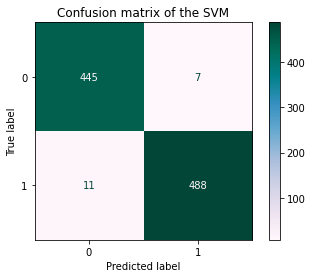

In [25]:
plot_confusion_matrix(svm, voiceX_test, voiceY_test, cmap='PuBuGn')
plt.title('Confusion matrix of the SVM')
plt.show()

### Случайный лес (Random Forest)

In [26]:
%time rf = RandomForestClassifier(n_estimators=100).fit(voiceX_train, voiceY_train)

voice_pred_rf = rf.predict(voiceX_test)
prf_rf=precision_recall_fscore_support(voiceY_test, voice_pred_rf, average='macro')

voice_score_rf = accuracy_score(voice_pred_rf, voiceY_test)
accuracy_results_rf = cross_val_score(rf, voiceX_train, voiceY_train, cv=kfold).mean()
Precision_rf = prf_rf[0]
Recall_rf = prf_rf[1]
f1_rf = prf_rf[2]

CPU times: user 645 ms, sys: 2.89 ms, total: 647 ms
Wall time: 649 ms


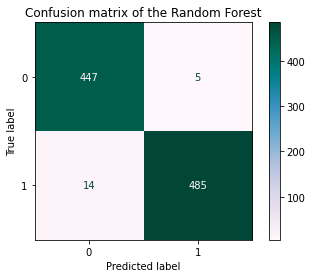

In [27]:
plot_confusion_matrix(rf,voiceX_test, voiceY_test, cmap='PuBuGn')
plt.title('Confusion matrix of the Random Forest')
plt.show()

**Также мы можем определить важность каждого признака согласно Random Forest Classifier и отобразить это на линейном графике.**

In [28]:
rf_importance = rf_feat_importance(rf, voiceDf1)
rf_importance.sort_values(by='Importance', ascending=False)

,cols,Importance
12,meanfun,0.330798
5,IQR,0.229155
3,Q25,0.140349
1,sd,0.069436
8,sp.ent,0.039133
9,sfm,0.034034
11,centroid,0.022644
10,mode,0.016736
0,meanfreq,0.016052
2,median,0.014864


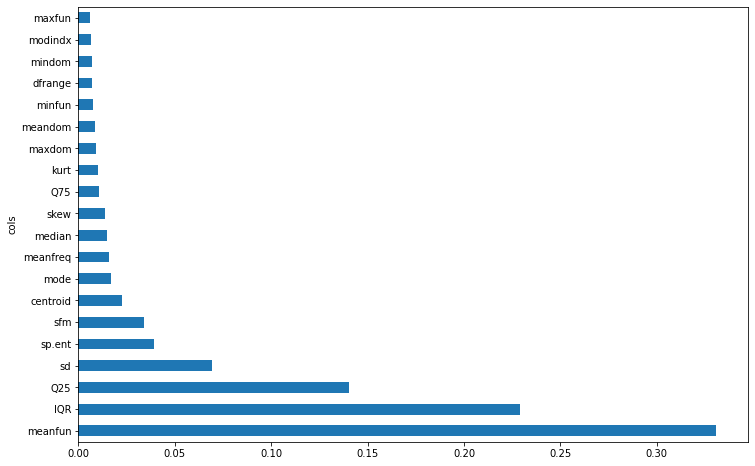

In [29]:
plot_fi(rf_importance);

**Так, ```meanfun``` является наиболее важным признаком среди всех, затем следует ```IQR```. Это вполне логично.**

## Кривые обучения
Строим графики кривых обучения для каждой модели, чтобы дать дополнительную информацию о производительности моделей

In [30]:
logreg_train_sizes, logreg_train_scores, logreg_valid_scores, *_ = learning_curve(best_logreg, voiceX_train, voiceY_train, n_jobs=-1,
                                                        random_state=42, cv=3)

knn_train_sizes, knn_train_scores, knn_valid_scores, *_ = learning_curve(knn, voiceX_train, voiceY_train, n_jobs=-1,
                                                        random_state=42, cv=3)

svm_train_sizes, svm_train_scores, svm_valid_scores, *_ = learning_curve(svm, voiceX_train, voiceY_train, n_jobs=-1,
                                                        random_state=42, cv=3)

rf_train_sizes, rf_train_scores, rf_valid_scores, *_ = learning_curve(rf, voiceX_train, voiceY_train, n_jobs=-1,
                                                        random_state=42, cv=3)

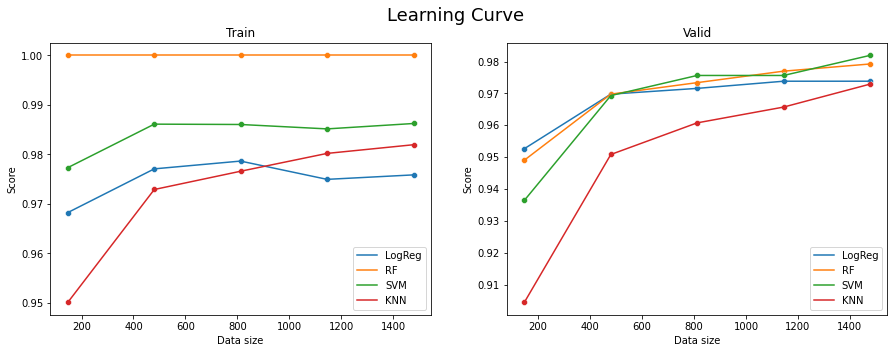

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Learning Curve', fontsize=18)

# Графики обучения
sns.scatterplot(ax=axes[0], x= logreg_train_sizes, y= logreg_train_scores.mean(axis=1))
sns.lineplot(ax=axes[0], x= logreg_train_sizes, y= logreg_train_scores.mean(axis=1))
sns.scatterplot(ax=axes[0], x= rf_train_sizes, y= rf_train_scores.mean(axis=1))
sns.lineplot(ax=axes[0], x= rf_train_sizes, y= rf_train_scores.mean(axis=1))
sns.scatterplot(ax=axes[0], x= svm_train_sizes, y= svm_train_scores.mean(axis=1))
sns.lineplot(ax=axes[0], x= svm_train_sizes, y= svm_train_scores.mean(axis=1))
sns.scatterplot(ax=axes[0], x= knn_train_sizes, y= knn_train_scores.mean(axis=1))
sns.lineplot(ax=axes[0], x= knn_train_sizes, y= knn_train_scores.mean(axis=1))
axes[0].set_title('Train')
axes[0].set_xlabel('Data size')
axes[0].set_ylabel('Score')
axes[0].legend(['LogReg', 'RF', 'SVM', 'KNN'])

# Графики тестовых 
sns.scatterplot(ax=axes[1], x= logreg_train_sizes, y= logreg_valid_scores.mean(axis=1))
sns.lineplot(ax=axes[1], x= logreg_train_sizes, y= logreg_valid_scores.mean(axis=1))
sns.scatterplot(ax=axes[1], x= rf_train_sizes, y= rf_valid_scores.mean(axis=1))
sns.lineplot(ax=axes[1], x= rf_train_sizes, y= rf_valid_scores.mean(axis=1))
sns.scatterplot(ax=axes[1], x= svm_train_sizes, y= svm_valid_scores.mean(axis=1))
sns.lineplot(ax=axes[1], x= svm_train_sizes, y= svm_valid_scores.mean(axis=1))
sns.scatterplot(ax=axes[1], x= knn_train_sizes, y= knn_valid_scores.mean(axis=1))
sns.lineplot(ax=axes[1], x= knn_train_sizes, y= knn_valid_scores.mean(axis=1))
axes[1].set_title('Valid')
axes[1].set_xlabel('Data size')
axes[1].set_ylabel('Score')
axes[1].legend(['LogReg', 'RF', 'SVM', 'KNN'])

plt.show()

### Таблица оценки производительности моделей

Ниже представленная таблица сравнивает примененные модели с использованием различных метрик оценки: model.score, кросс-валидация, точность, полнота, F1-оценка,  `model.score`, `Cross Validation`,  `Precision`, `Recall`, `F1 Score` чтобы увидеть, какая модель является оптимальной для этого набора данных.

In [44]:
model_performance_table = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'RF', 'LogReg'],
    'Model Score': [voice_score_svm, voice_score_knn, voice_score_rf, voice_score_logreg],
    'Cross Validation': [accuracy_results_svm, accuracy_results_knn, accuracy_results_rf, accuracy_results_logreg],
    'Valid Precision': [Precision_svm, Precision_knn, Precision_rf, Precision_logreg],
    'Valid Recall': [Recall_svm, Recall_knn, Recall_rf, Recall_logreg],
    'Valid F1 Score': [f1_svm, f1_knn, f1_rf, f1_logreg]
})

model_performance_table.sort_values(by="Model Score", ascending=False)

,Model,Model Score,Cross Validation,Valid Precision,Valid Recall,Valid F1 Score
0,SVM,0.981073,0.980602,0.980868,0.981235,0.981034
2,RF,0.980021,0.979250,0.979714,0.980441,0.979989
1,KNN,0.978970,0.973388,0.978708,0.979231,0.978930
3,LogReg,0.973712,0.972933,0.973933,0.973387,0.973633


---
SVM оказалась лидером по всем метрикам, включая точность модели, точность кросс-валидации, точность валидации, полноту валидации и F1-оценку валидации. Это говорит о высокой надежности и эффективности этой модели.

KNN показала немного меньшие результаты по сравнению с SVM, но все равно достаточно высокие, чтобы считать эту модель эффективной. Она может быть хорошим выбором в случаях, когда SVM не подходит по каким-либо причинам.

В общем, все модели показали хорошие результаты, что говорит об их эффективности в решении задачи распознавании голоса, а классификации пола по голосу.

---

Так, мы исследовали и предобработали датасет из примерно 31 тысячи строк уникальных записей голосов мужчин и женщин (50%/50%) и обучили ряд моделей машинного обучения

## TensorFlow

### Создание Keras модели

In [33]:
def create_model():
   
    model = Sequential()
    model.add(Dense(256, input_shape=voiceX_train.shape))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # Один выходной нейрон с сигмоидной функцией активации
    model.add(Dense(1, activation="sigmoid"))
    # используем функцию потерь binary_crossentropy
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    
    model.summary()
    return model

1. Создается последовательная модель `Sequential`.
2. Добавляется полносвязный слой с 256 нейронами. Входная форма для этого слоя - размерность обучающих данных.
3. Добавляется слой Dropout с параметром 0.3. Так, во время обучения 30% нейронов в предыдущем слое будут случайно отключаться на каждом шаге обучения, чтобы предотвратить переобучение.
4. Добавляются еще три пары слоев Dense и Dropout для дополнительного обучения и регуляризации модели.
5. Добавляется последний слой Dense с одним нейроном и функцией активации `sigmoid`. Это делает модель подходящей для бинарной классификации (в данном случае, определение пола).
6. Модель компилируется с функцией потерь `binary_crossentropy` (для бинарной классификации).

In [34]:
model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2217, 256)         5376      
_________________________________________________________________
dropout (Dropout)            (None, 2217, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 2217, 256)         65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2217, 256)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 2217, 128)         32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2217, 128)         0         
_________________________________________________________________
dense_3 (Dense)              (None, 2217, 128)         1

##### Предупреждаем переобучение

Останавливаем обучение модели при достижении 95% точности на обучающей выборке.

In [35]:
class myCallback(tf.keras.callbacks.Callback):
    # Вызываем в конце каждой эпохи
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.94):
            print("nДостигнута точность 94%, - дальнейшее обучение отменяется!")
            self.model.stop_training = True   # Останавливаем обучение

In [36]:
callbacks = myCallback()

#### Обучаем Sequantial модель

In [45]:
BATCH_SIZE = 64
EPOCHS = 50

model.fit(voiceX_train, voiceY_train, 
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=[callbacks])

Epoch 1/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0339 - accuracy: 0.9851
nДостигнута точность 94%, - дальнейшее обучение отменяется!


При установленном callback обучение происходит не более чем за 5 эпох.

#### Оцениваем на тесте

In [46]:
print(f"Evaluating the model using {len(voiceX_test)} samples...")
loss, accuracy = model.evaluate(voiceX_test,voiceY_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.4f}%")

Evaluating the model using 951 samples...
Loss: 0.0735
Accuracy: 97.6866%


In [48]:
preds = []

for i in range(0, len(voiceX_test)):
    preds.append(model.predict(voiceX_test)[i][0])
    
    
predictions = [1 if val > 0.5 else 0 for val in preds]

In [49]:
tf_Sequantial_accuracy = accuracy_score(voiceY_test, predictions)
print("Общая оценка точности: {}".format(tf_Sequantial_accuracy))

Общая оценка точности: 0.9768664563617245


Здесь вспомним точности других моделей:

In [41]:
model_performance_table.sort_values(by="Model Score", ascending=False)

,Model,Model Score,Cross Validation,Valid Precision,Valid Recall,Valid F1 Score
0,SVM,0.981073,0.980602,0.980868,0.981235,0.981034
2,RF,0.980021,0.979250,0.979714,0.980441,0.979989
1,KNN,0.978970,0.973388,0.978708,0.979231,0.978930
3,LogReg,0.973712,0.972933,0.973933,0.973387,0.973633


**При нескольких запусках представленная Keras модель стабильно опережает по точности логистическую регрессию, но имеет чуть меньшую точность по сравнению с другими моделями. Все score последовательной модели в диапазоне от 0.975 до 0.98.**

In [56]:
y_pred_keras = (model.predict(voiceX_test).ravel() > 0.5).astype(int)
voice_score_keras = accuracy_score(voiceY_test, y_pred_keras)
prf_keras = precision_recall_fscore_support(voiceY_test, y_pred_keras, average='macro')
Precision_keras = prf_keras[0]
Recall_keras = prf_keras[1]
f1_keras = prf_keras[2]

In [63]:
model_performance_table = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'RF', 'LogReg', 'Keras'],
    'Model Score': [voice_score_svm, voice_score_knn, voice_score_rf, voice_score_logreg, voice_score_keras],
    'Cross Validation': [accuracy_results_svm, accuracy_results_knn, accuracy_results_rf, accuracy_results_logreg, None],
    'Valid Precision': [Precision_svm, Precision_knn, Precision_rf, Precision_logreg, Precision_keras],
    'Valid Recall': [Recall_svm, Recall_knn, Recall_rf, Recall_logreg, Recall_keras],
    'Valid F1 Score': [f1_svm, f1_knn, f1_rf, f1_logreg, f1_keras]
})

model_performance_table = model_performance_table.sort_values(by="Model Score", ascending=False).reset_index(drop=True).reset_index(drop=True).set_index(model_performance_table.index + 1)

In [64]:
model_performance_table

,Model,Model Score,Cross Validation,Valid Precision,Valid Recall,Valid F1 Score
1,SVM,0.981073,0.980602,0.980868,0.981235,0.981034
2,RF,0.980021,0.979250,0.979714,0.980441,0.979989
3,KNN,0.978970,0.973388,0.978708,0.979231,0.978930
4,Keras,0.976866,NaN,0.976567,0.977227,0.976827
5,LogReg,0.973712,0.972933,0.973933,0.973387,0.973633


#### Далее рассмотрим график ROC-AUC кривой Keras и сравним, например, с ROC-AUC кривой логистической регрессии.

#### Keras

In [52]:
y_pred_keras = model.predict(voiceX_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(voiceY_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

#### Логистическая регрессия

In [53]:
y_pred_lr = best_logreg.predict_proba(voiceX_test)[:, 1]
fpr_lr, tpr_lr, thresholds_rf = roc_curve(voiceY_test, y_pred_lr)
auc_lr = auc(fpr_lr, tpr_lr)

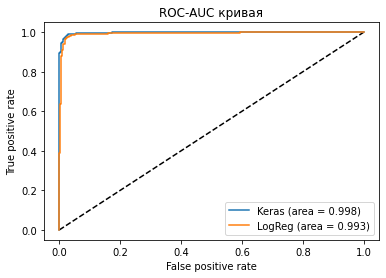

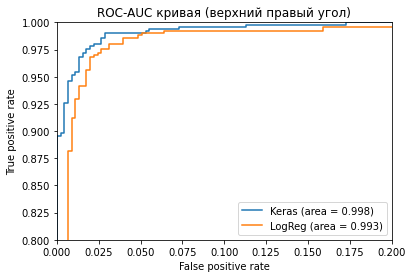

In [65]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_lr, tpr_lr, label='LogReg (area = {:.3f})'.format(auc_lr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-AUC кривая')
plt.legend(loc='best')
plt.show()

# Zoom .
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_lr, tpr_lr, label='LogReg (area = {:.3f})'.format(auc_lr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-AUC кривая (верхний правый угол)')
plt.legend(loc='best')
plt.show()

Получаем очень высокие значения roc-auc, Keras справляется практически на 1, логистическая регрессия чуть выше 0.99. Это означает, что модели отлично различают классы - успех в задаче классификации пола по голосу.

#### Probability density function (PDF)

Плотность вероятности показывает, как вероятности распределены для каждой группы. Если модель хорошо справляется с задачей классификации, ожидаем увидеть два отчетливых пика на графике: один около 0 и один около 1.

In [70]:
def plot_pdf(y_pred, y_test, name=None, smooth=500):
    positives = y_pred[y_test == 1]
    negatives = y_pred[y_test == 0]
    N = positives.shape[0]
    n =10
    s = positives
    p, x = np.histogram(s, bins=n) 
    x = x[:-1] + (x[1] - x[0]) / 2   
    f = UnivariateSpline(x, p, s=n)
    plt.plot(x, f(x))

    N = negatives.shape[0]
    n = 10
    s = negatives
    p, x = np.histogram(s, bins=n) 
    x = x[:-1] + (x[1] - x[0]) / 2  
    f = UnivariateSpline(x, p, s=n)
    plt.plot(x, f(x))
    plt.xlim([0.0, 1.0])
    plt.xlabel('density')
    plt.ylabel('density')
    plt.title('PDF-{}'.format(name))
    plt.show()

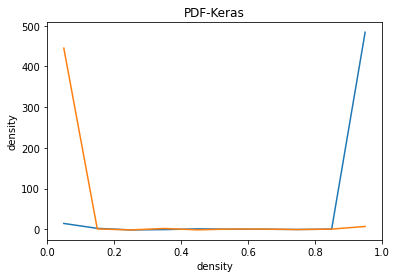

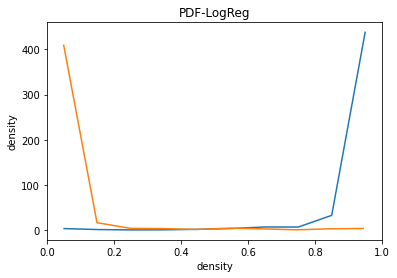

In [71]:
plot_pdf(y_pred_keras, voiceY_test, 'Keras')
plot_pdf(y_pred_lr, voiceY_test, 'LogReg')

Видим два отчётливых пика на графиках PDF, что ещё раз подтверждает качество моделей.

## Выводы

#### Мы получили очень высокие точности моделей на тестах, и это - результат поэтапной работы:
 - Датасет:  
         Из анализа стало ясно, что найденный набор данных `voice.csv` достаточно хорошо подготовлен для обчения моделей на нём. Пропуски отсутствуют, все признаки численные. Выбросы минимальны (только 1 признак имеет заметное их количество). Таргет сбалансирован, нет проблемы дисбаланса классов, можем использовать метрику accuracy как репрезентативную. 
 - Предобработка:
         Разбили на обучающую и тестовую выборки в отношении 70 на 30, после чего масштабировали все признаки при помощи StandardScaler.
 - Обучение классических моделей:
         Использовали различные модели классификации. Задействовали GridSearchCV для поиска оптимальных гиперпараметров. Смотрели несколько метрик: точность score, точность на кросс-валидации (KFold(5)), precision, recall, f1-score. Все метрики для удобства занесли в таблицу моделей и удобно отсортировали, чтобы сделать дальнейшие выводы по каждой из них.
 - Обучение Keras:
         Создали последовательную модель, предосмотрели её переобучение в Callback. Протестировали. Получили высокие метрики. Сравнили с логистической регрессией, построили roc-auc кривые и графики плотности вероятностей, убедились в высоком качестве.


In [74]:
model_performance_table

,Model,Model Score,Cross Validation,Valid Precision,Valid Recall,Valid F1 Score
1,SVM,0.981073,0.980602,0.980868,0.981235,0.981034
2,RF,0.980021,0.979250,0.979714,0.980441,0.979989
3,KNN,0.978970,0.973388,0.978708,0.979231,0.978930
4,Keras,0.976866,NaN,0.976567,0.977227,0.976827
5,LogReg,0.973712,0.972933,0.973933,0.973387,0.973633


#### Исходя из полученной таблицы, можно сделать следующие выводы:

1. SVM показывает наилучшие результаты по всем метрикам. Это указывает на то, что SVM хорошо справляется с задачей классификации пола по голосу.

2. Случайный лес (RF) также показывает очень хорошие результаты, особенно в метрике _recall_.

3. Модель KNN показывает немного худшие результаты по сравнению с SVM и RF, но все равно достаточно хорошие.

4. Keras показывает хорошие результаты, но немного уступает другим моделям. Отсутствие значения кросс-валидации связано с тем, что кросс-валидация обычно не используется при обучении нейронных сетей из-за большого времени обучения.

5. Логистическая регрессия показывает наименьшие значения по всем метрикам, что указывает на то, что она менее подходит для задачи распознавания голоса по сравнению с другими моделями.

В целом, все модели показывают довольно высокую точность, что говорит о том, что они хорошо справляются с задачей классификации на наборе данных о голосах. Но выделим **SVM и Random Forest как наиболее предпочтительные для классификации пола на основе голоса**.

Можно отметить, что так выглядят топ-3 признака по важности у модели случайного леса:
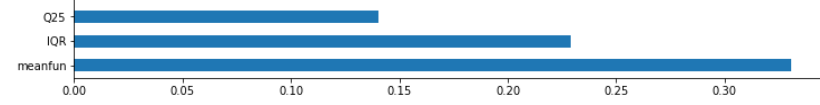

В контексте задачи определения пола по акустическим сигналам:

1. `Q25` (первый квантиль):   
Мужские и женские голоса обычно различаются по высоте тона. Мужские голоса обычно имеют более низкую основную частоту по сравнению с женскими голосами. Первый квантиль может помочь отразить эту разницу, так как он представляет собой значение, ниже которого падает 25% наблюдений в группе данных.

2. `IQR` (интерквартильный размах):  
Интерквартильный размах может отражать различия в вариабельности тональных характеристик между мужскими и женскими голосами. Например, мужские голоса могут иметь больший размах частот, в то время как женские голоса могут быть более узкими и стабильными.

3. `meanfun` (среднее значение основной частоты):  
Представляет среднее значение основной частоты, измеренной в акустическом сигнале. Основная частота является ключевым атрибутом звукового сигнала и может значительно варьироваться между мужскими и женскими голосами. Мужские голоса обычно имеют более низкую основную частоту по сравнению с женскими голосами.

Эти признаки имеют больший вес, что было отмечено ещё на матрице корреляций, где их связь с целевым `label` была заметно сильнее, чем у других признаков.